
# Final exam
(rev1)

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\Z}{\mathbf{Z}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
$$

__<div style="text-align: right"> EE370: Software lab, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_

This take-home exam contains one question. _Your answers should be turned in to the instructor and the course assistant no later than 1:30pm on December 17th, and you are not allowed to discuss the exam with anyone until then._ The only exception is when you email the instructor for clarification.

Your answers should be as concise as possible while self-explaining that the presented results are reasonable. **_Poorly presented answers or list of graphs without any explanation, for which the graders have to closely examine or even run the code to check the correctness, will get no credit._** We suggest you spend at least an hour in carefully writing down concise explanations on your results.

Write your student ID and name below. **_Typing your name implies that you acknowledge and accept the Kyung Hee University Honor Code._**

<br>

- STUDENT ID: 

- STUDENT NAME: 

<br>

_Kyung Hee University Honor Code:_

1. The honor code is a commitment of students, individually and collectively, that they will not provide or receive any impermissible aid in examinations as well as other activities used as the basis of grading, and that they will do their best for the sake of the integrity of the community.
2. The faculty also assumes obligations to provide students with the environment in which students can best practice the honor code, and does its part in building the academic integrity of the community.

<br>

---
## Simultaneous localization and mapping (SLAM)

In computational geometry and robotics, simultaneous localization and mapping (SLAM) is the computational problem of constructing or updating a map of an unknown environment while simultaneously keeping track of an agent's location within it. While this initially appears to be a chicken-and-egg problem there are several algorithms known for solving it, at least approximately, in tractable time for certain environments. Popular approximate solution methods include the particle filter, extended Kalman filter, Covariance intersection, and GraphSLAM. SLAM algorithms are used in navigation, robotic mapping and odometry for virtual reality or augmented reality.

SLAM algorithms are tailored to the available resources, hence not aimed at perfection, but at operational compliance. Published approaches are employed in self-driving cars, unmanned aerial vehicles, autonomous underwater vehicles, planetary rovers, newer domestic robots and even inside the human body. ([Wikipedia page on SLAM](https://en.wikipedia.org/wiki/Simultaneous_localization_and_mapping))

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Ouster_OS1-64_lidar_point_cloud_of_intersection_of_Folsom_and_Dore_St%2C_San_Francisco.png" width="800" title="Daniel L. Lu, CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons"> 

< SLAM performed on an unmanned self-driving car. Daniel L. Lu, CC BY 4.0, via Wikimedia Commons >
</center>

<br>

This problem considers a (wheeled) robot navigating in a 2D plane, where 10 fixed landmarks (whose positions are initially unknown to the robot) exist. Running the following cell generates and displays the ground-truth positions of the landmarks on the map. We denote the position of the $i$-th landmark by $m^{(i)}=\left(m_x^{(i)},m_y^{(i)}\right)\in\R^2$, and these are given in `pos_landmarks`.
Note again that the landmark positions are initially unknown to the robot.

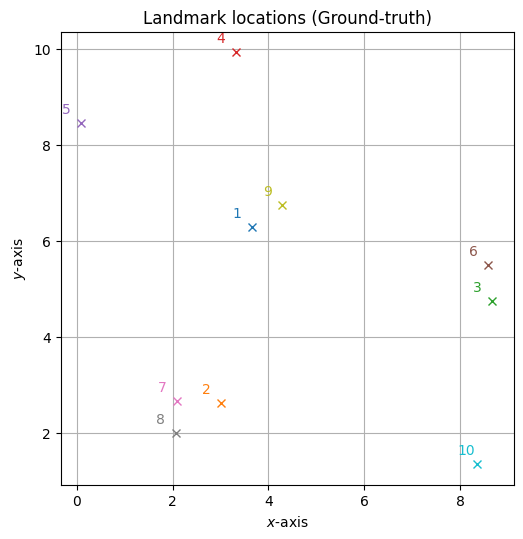

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Deg2Rad = np.pi/180
np.random.seed(370)

n_landmarks = 10
pos_landmarks = np.random.rand(2,n_landmarks)*10 #Random 랜드마크 생성

plt.figure(dpi=100, figsize=(6,6))
for i in range(n_landmarks):
  plt.plot(pos_landmarks[0,i], pos_landmarks[1,i], 'x', \
           color=plt.cm.tab20(i/n_landmarks)) 
  plt.text(pos_landmarks[0,i]-0.4, pos_landmarks[1,i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks)) #text
plt.axis('square')
plt.title('Landmark locations (Ground-truth)')
plt.xlabel(r'$x$-axis')
plt.ylabel(r'$y$-axis')
plt.grid()
plt.show()

<br>

The next cell generates the robot trajectory and the sensor data. 

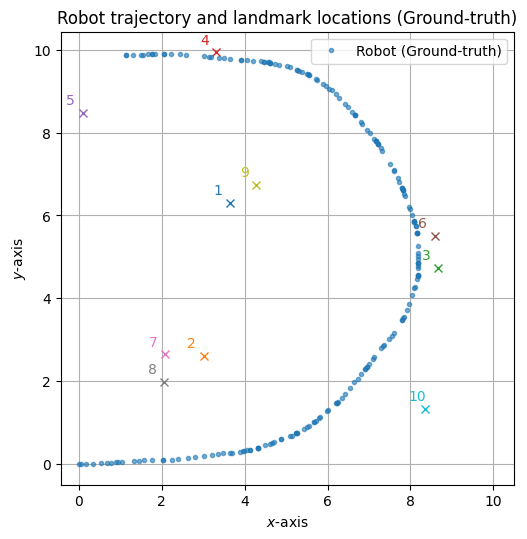

In [3]:
tf = 10
dt = 0.05

t= np.arange(0,tf+dt,dt)
N = int(tf/dt) #횟수
T = len(t)

vel_robot = np.ones(T)*2 #초기 속도 2
omg_robot = np.ones(T)*20*Deg2Rad #초기 각속도 20도
vel_robot += np.random.randn(T)*2 #속도 = 2 + 가우시안 * 2
vel_robot[vel_robot<0] = 0 #속도가 0보다 작으면 0으로
omg_robot += np.random.randn(T)*40*Deg2Rad #20+ 가우시안 * 40도

pos_robot_0 = np.zeros(2) #초기 위치 (0,0)
hed_robot_0 = 0 #로봇 방향
pos_robot = np.diag(pos_robot_0)@np.ones((2,T)) #np.diag(pos_robot_0) = [[0,0],[0,0]], T까지의 초기 위치 (0.0)
hed_robot = hed_robot_0*np.ones(T) #T까지의 초기 방향 0

e_odm_vel = 2             # odometry velocity error 
e_odm_omg = 40*Deg2Rad    # odometry angular rate error   
e_sen_r = 1               # lidar range error
e_sen_b = 10*Deg2Rad      # lidar bearing error 각도 오류?

# lidar
rng_lidar = np.zeros((n_landmarks,T)) #행 : 각 랜드 마크, T : 시간 마다 --> 각 시간 마다 랜드마크 거리 측정값 저장
brg_lidar = np.zeros((n_landmarks,T)) #행 : 각 랜드 마크, T : 시간 마다 --> 각 시간 마다 랜드마크 각도 측정값 저장
# odometry 
vel_odmtry = vel_robot + np.random.randn(T)*e_odm_vel  #Odom 계산
omg_odmtry = omg_robot + np.random.randn(T)*e_odm_omg  

for k in range(T-1):
  for i in range(n_landmarks):
    rng_lidar[i,k] = np.linalg.norm(pos_landmarks[:,i] - pos_robot[:,k]) 
    brg_lidar[i,k] = np.arctan2(pos_landmarks[1,i]-pos_robot[1,k], \
                                  pos_landmarks[0,i]-pos_robot[0,k]) 
    brg_lidar[i,k] -= hed_robot[k] #로봇이 보고 있던 방향 보정
    rng_lidar[i,k] += np.random.randn()*e_sen_r   #에러 포함
    brg_lidar[i,k] += np.random.randn()*e_sen_b   #에러 포함

    brg_lidar[i,k] = np.arctan2(np.sin(brg_lidar[i,k]), \
                                 np.cos(brg_lidar[i,k])) #최종 각도
    
  hed_robot[k+1] = hed_robot[k] + dt*omg_robot[k] #각속도 반영해 로봇 방향 변경
  pos_robot[:,k+1] = pos_robot[:,k] + \
    dt*vel_robot[k]*np.array([np.cos(hed_robot[k]), \
                              np.sin(hed_robot[k])]) #위치 변경==초기 위치+이동

plt.figure(dpi=100, figsize=(6,6))
for i in range(n_landmarks):
  plt.plot(pos_landmarks[0,i], pos_landmarks[1,i], 'x', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(pos_landmarks[0,i]-0.4, pos_landmarks[1,i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
plt.plot(pos_robot[0,:], pos_robot[1,:], '.', alpha=0.6, \
         color=plt.cm.tab20(0), label='Robot (Ground-truth)') #로봇 궤적
plt.axis('square')
plt.legend()
plt.title('Robot trajectory and landmark locations (Ground-truth)')
plt.xlabel(r'$x$-axis')
plt.ylabel(r'$y$-axis')
plt.grid()
plt.show()

The robot starts to move from the origin at $t_0$, and the ground-truth trajectory $p_0, p_1, \dots, p_N \in\R^2$ at equally spaced sample time $t_0, t_1, \dots, t_N$ (with sampling interval $\Delta t$) is displayed in blue. However, note again that none of the above (trajectory of the robot and the location of the landmarks) is known to the robot. What it knows is 1) its initial position and 2) the sensor measurements from two different sensors, the odometer and the LIDAR (light detection and ranging), obtained at $t_0, t_1, \dots, t_N$.

- The robot's initial condition: it is stationary at the origin at $t=0$, in other words, $p_0 = (0,0)$.

- The robot's odometry measurement; it measures the linear velocity, $v_k\in\R$, along its wheel, and the angular rate, $\omega_k\in\R$, of the robot. The velocity and the angular rate are related to the position, $p_k=\left(p_{k,x},p_{k,y}\right)\in\R^2$, and the heading, $\theta_k\in\R$, by:

\begin{align*}
  p_{k+1,x} &= p_{k,x} + v_k \Delta t \cos\theta_k \\
  p_{k+1,y} &= p_{k,y} + v_k \Delta t \sin\theta_k \\
  \theta_{k+1} &= \theta_k + \omega_k \Delta t
\end{align*}
<center>
<img src="https://jonghank.github.io/ee370/files/odometry.png" width="400" > 
</center>

- The relative range and the relative bearing (direction) of the 10 landmarks from the robot. The relative range and the bearing measurement for the $i$-th landmark are:

\begin{align*}
  r_{k}^{(i)} &= \sqrt{\left(m_x^{(i)}-p_{k,x}\right)^2+\left(m_y^{(i)}-p_{k,y}\right)^2} \\
  \phi_{k}^{(i)} &= \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right) - \theta_k
\end{align*}

<center>
<img src="https://jonghank.github.io/ee370/files/lidar.png" width="400" > 
</center>

<br>

Unfortunately, all the measurements are severely corrupted by noise, though this is quite natural. For example the LIDAR that we used in this simulation is quite cheap, and is about 1 meter wrong in range and about 10 degrees wrong in bearing.

The velocity measurements from the odometer, $v_0, v_1, \dots, v_{N}$, are given in `vel_odmtry`, and the angular rate measurements from the odometer, $\omega_0, \omega_1, \dots, \omega_{N}$ are given in `omg_odmtry`. The range relative range and the relative bearing measurements are given in `rng_lidar` and `brg_lidar`. Note the size of `rng_lidar` and `brg_lidar`; the $i$-th row represents the measurements obtained for the $i$-th landmark, $r_0^{(i)}, r_1^{(i)}, \dots, r_N^{(i)}$ and $\phi_0^{(i)}, \phi_1^{(i)}, \dots, \phi_N^{(i)}$.

Again we summarize below the available information you can use for this problem.

- `pos_robot_0`: Initial position of the robot in meters, $p_0\in\R^2$.
- `hed_robot_0`: Initial heading angle of the robot, in radians, $\theta_0\in\R$.
- `dt`: Sampling interval for each measurement, $\Delta t = t_{k+1} - t_k$ for all $k=0,\dots,N-1$.
- `vel_odmtry`: The history of velocity measurements from the odometry reading in m/s. This array equals to
$$
  \bmat{v_0 & v_1 & \cdots & v_N}\in \R^{N+1}
$$
- `omg_odmtry`: The history of angular rate measurements from the odometry reading in radian per second. This arrary equals to
$$
  \bmat{\omega_0 & \omega_1 & \cdots & \omega_N}\in \R^{N+1}
$$
- `rng_lidar`: The history of relative range measurements to 10 landmarks obtained from the LIDAR in meters. This array equals to
$$
  \bmat{r_0^{(1)} & r_1^{(1)} & \cdots & r_N^{(1)} \\
  r_0^{(2)} & r_1^{(2)} & \cdots & r_N^{(2)} \\
  \vdots & \vdots & \ddots & \vdots \\
  r_0^{(10)} & r_1^{(10)} & \cdots & r_N^{(10)} 
  }\in \R^{10\times (N+1)}
$$
- `brg_lidar`: The history of relative bearing measurements to 10 landmarks obtained from the LIDAR in radians. This array equals to
$$
  \bmat{\phi_0^{(1)} & \phi_1^{(1)} & \cdots & \phi_N^{(1)} \\
  \phi_0^{(2)} & \phi_1^{(2)} & \cdots & \phi_N^{(2)} \\
  \vdots & \vdots & \ddots & \vdots \\
  \phi_0^{(10)} & \phi_1^{(10)} & \cdots & \phi_N^{(10)} 
  }\in \R^{10\times (N+1)}
$$

<br>

So your job in this problem is to use these data for finding the positions of the moving robot (this is called localization), and the positions of the fixed landmarks (this is called mapping), simultaneously. The ground-truth trajectory of the robot and the locations of the landmarks are given in `pos_robot` and `pos_landmarks`, however you should not use them for your SLAM computation; you may use them only when you want to validate your SLAM solution.

<br>

_**(Problem 1a - Dead reckoning)**_ We will first try to use the odometry data to find the positions of the robot. 

Recall that the velocity, $v_k\in\R$, and the angular rate, $\omega_k\in\R$ are related to the position, $p_k=(p_{k,x},p_{k,y})\in\R^2$, and the heading, $\theta_k\in\R$ as follows.

\begin{align*}
  p_{k+1,x} &= p_{k,x} + v_k \Delta t \cos\theta_k \\
  p_{k+1,y} &= p_{k,y} + v_k \Delta t \sin\theta_k \\
  \theta_{k+1} &= \theta_k + \omega_k \Delta t
\end{align*}

Use these relations to find $p_0, \dots, p_N$ and $\theta_0, \dots, \theta_N$. Display the robot's trajectory on a 2D (x-y) plot. Compare it with the ground-truth trajectory, by overlapping those on the same plot. The ground-truth robot trajectory is given in `pos_robot`.

This technique simply integrates the noisy odometry data and is called _dead reckoning_, which usually diverges with time because the noise in the odometer data is also integrated. You should be able to observe this from your result. Also, notice that this technique does not give you any clue on the landmark locations.

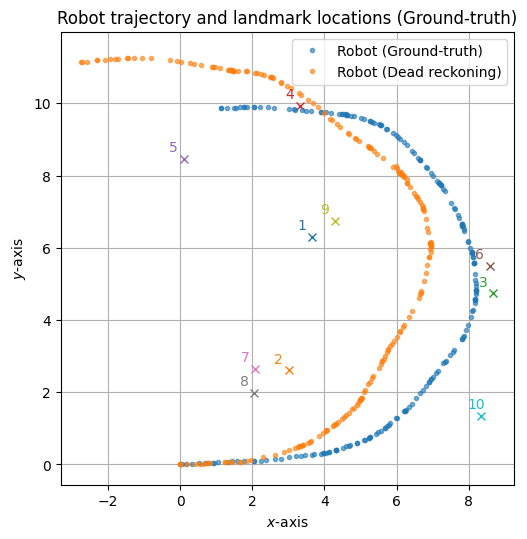

In [4]:
pos_robot_0_dr = np.zeros(2) #Dr초기 위치 (0,0)
hed_robot_0_dr = 0 #Dr 초기로봇 방향
pos_robot_dr = np.diag(pos_robot_0_dr)@np.ones((2,T)) #T까지의 초기 위치 (0.0)
hed_robot_dr = hed_robot_0_dr*np.ones(T) #T까지의 초기 방향 0

e_odm_vel = 2             # odometry velocity error 
e_odm_omg = 40*Deg2Rad    # odometry angular rate error   
e_sen_r = 1               # lidar range error
e_sen_b = 10*Deg2Rad      # lidar bearing error 

for k in range(T-1):
    
  hed_robot_dr[k+1] = hed_robot_dr[k] + dt*omg_odmtry[k] #각속도 반영해 로봇 Dr 방향 변경
  pos_robot_dr[:,k+1] = pos_robot_dr[:,k] + \
    dt*vel_odmtry[k]*np.array([np.cos(hed_robot_dr[k]), \
                              np.sin(hed_robot_dr[k])]) #Dr 위치

plt.figure(dpi=100, figsize=(6,6))
for i in range(n_landmarks):
  plt.plot(pos_landmarks[0,i], pos_landmarks[1,i], 'x', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(pos_landmarks[0,i]-0.4, pos_landmarks[1,i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
plt.plot(pos_robot[0,:], pos_robot[1,:], '.', alpha=0.6, \
         color=plt.cm.tab20(0), label='Robot (Ground-truth)') #로봇 궤적
plt.plot(pos_robot_dr[0,:], pos_robot_dr[1,:], '.', alpha=0.6, \
         color=plt.cm.tab20(2), label='Robot (Dead reckoning)') #Dead reckoning 궤적
plt.axis('square')
plt.legend()
plt.title('Robot trajectory and landmark locations (Ground-truth)')
plt.xlabel(r'$x$-axis')
plt.ylabel(r'$y$-axis')
plt.grid()
plt.show()

<br>

The SLAM algorithm uses the extended Kalman filter along with the odometer and the LIDAR measurement data, in order to simultaneously compute the estimates of the position of the moving robot, $p_0,\dots,p_N\in\R^2$ and the position of the fixed landmarks, $m^{(1)}, \dots, m^{(10)}\in\R^2$. 

<br>

We first define the state vector $x_k$ which contains the positions to be estimated,

$$
  x_k = \bmat{p_{k,x} \\ p_{k,y} \\ \theta_k \\ m_x^{(1)} \\ m_y^{(1)} \\ \vdots \\ m_x^{(10)} \\ m_y^{(10)}} \in \R^{23}
$$

and define the transition function $f(x_{k},v_k,\omega_k)$ that defines the state transition from $x_k$ to $x_{k+1}$,

$$
  x_{k+1} = f(x_{k},v_k,\omega_k) + e_k
$$

where $e_k$ is the process noise acting on the transition dynamics.
We can write the state transition function more explicitly as,

\begin{align*}
  x_{k+1} &= \bmat{p_{k+1,x} \\ p_{k+1,y} \\ \theta_{k+1} \\ m_{x}^{(1)} \\ m_{y}^{(1)} \\ \vdots \\ m_{x}^{(10)} \\ m_{y}^{(10)}}
  = \bmat{p_{k,x} + v_k \Delta t \cos\theta_k \\
  p_{k,y} + v_k \Delta t \sin\theta_k \\
  \theta_k + \omega_k \Delta t \\
  m_x^{(1)} \\ m_y^{(1)} \\
  \vdots \\ m_x^{(10)} \\ m_y^{(10)}  
  } + e_k = f(x_{k},v_k,\omega_k) + e_k
\end{align*}

<br>

We also define the measurement vector $y_k$ that lists the LIDAR measurements, 

$$
  y_k = \bmat{r_k^{(1)} \\ \vdots \\ r_k^{(10)} \\ 
  \phi_k^{(1)} \\ \vdots \\ \phi_k^{(10)} } \in\R^{20}
$$

and the measurement function $h(x_k)$ that defines the LIDAR measurement information from the state vector $x_k$

$$
  y_k = h(x_k) + n_k
$$

where $n_k$ represents the measurement noise on the LIDAR data. More explicitly,

\begin{align*}
  y_k = \bmat{r_k^{(1)} \\ \vdots \\ r_k^{(10)} \\ 
  \phi_k^{(1)} \\ \vdots \\ \phi_k^{(10)} } = 
  \bmat{  
  \sqrt{\left(m_x^{(1)}-p_{k,x}\right)^2+\left(m_y^{(1)}-p_{k,y}\right)^2} \\
  \vdots \\
  \sqrt{\left(m_x^{(10)}-p_{k,x}\right)^2+\left(m_y^{(10)}-p_{k,y}\right)^2} \\
  \tan^{-1}\left(\frac{m_y^{(1)}-p_{k,y}}{m_x^{(1)}-p_{k,x}}\right)-\theta_k 
  \\ \vdots \\
  \tan^{-1}\left(\frac{m_y^{(10)}-p_{k,y}}{m_x^{(10)}-p_{k,x}}\right)-\theta_k
} 
  + n_k = h(x_k) + n_k
\end{align*}



<br>

Notice that the transition dynamics $f(x_{k},v_k,\omega_k)$ and the measurement equation $h(x_k)$ are _not linear_ in the state variable $x_k$. Recall that those were linear in your 
[Kalman filter example](https://nbviewer.jupyter.org/gist/jonghank/2550d608130f05e23080e8d576e4bf3e).

The Jacobian matrices can be used to linearize $f(x_{k},v_k,\omega_k)$ and $h(x_k)$. The Jacobian matrix, $\nabla g $, of a vector-valued function $g(x)\in\R^m$ with respect to $x\in\R^n$ is the matrix of all its first-order partial derivatives. 

$$
{ \nabla g ={\begin{bmatrix}{\dfrac {\partial  {g} }{\partial x_{1}}}&\cdots &{\dfrac {\partial  {g} }{\partial x_{n}}}\end{bmatrix}}={\begin{bmatrix}{\dfrac {\partial g_{1}}{\partial x_{1}}}&\cdots &{\dfrac {\partial g_{1}}{\partial x_{n}}}\\\vdots &\ddots &\vdots \\{\dfrac {\partial g_{m}}{\partial x_{1}}}&\cdots &{\dfrac {\partial g_{m}}{\partial x_{n}}}\end{bmatrix}}}
$$

<br>

So the Jacobian of $f(\cdot)$ with respect to $x_k$, $\nabla f$ is a $23\times 23$ matrix with

\begin{align*}
\nabla f_{i,i} &= 1 \qquad\qquad\qquad\qquad\qquad \text{for all } i=1,2,\dots,23\\
\nabla f_{1,3} &= \frac{\partial}{\partial \theta_{k}}\left(p_{k,x} + v_k \Delta t \cos\theta_k\right) \\
\nabla f_{2,3} &= \frac{\partial}{\partial \theta_{k}}\left(p_{k,y} + v_k \Delta t \sin\theta_k\right) \\
\end{align*}

and the rest being all zeros. Note that $\nabla f$ is not a constant matrix, but it changes with the arguments of $f(\cdot)$.

<br>

The Jacobian of $h(\cdot)$ with respect to $x_k$, $\nabla h$ is a $20 \times 23$ matrix with

\begin{align*}
\nabla h_{i,1} &= \frac{\partial}{\partial p_{k,x}} 
\left( \sqrt{\left(m_x^{(i)}-p_{k,x}\right)^2+\left(m_y^{(i)}-p_{k,y}\right)^2} \right) \\
\nabla h_{i,2} &= \frac{\partial}{\partial p_{k,y}} 
\left( \sqrt{\left(m_x^{(i)}-p_{k,x}\right)^2+\left(m_y^{(i)}-p_{k,y}\right)^2} \right)  \\
\nabla h_{i,2i+2} &= \frac{\partial}{\partial m_x^{(i)}} 
\left( \sqrt{\left(m_x^{(i)}-p_{k,x}\right)^2+\left(m_y^{(i)}-p_{k,y}\right)^2} \right) \\
\nabla h_{i,2i+3} &= \frac{\partial}{\partial m_y^{(i)}} 
\left( \sqrt{\left(m_x^{(i)}-p_{k,x}\right)^2+\left(m_y^{(i)}-p_{k,y}\right)^2} \right) 
\end{align*}

and 

\begin{align*}
\nabla h_{i+10,1} &= \frac{\partial}{\partial p_{k,x}} 
\left( \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right)-\theta_k \right)  \\
\nabla h_{i+10,2} &= \frac{\partial}{\partial p_{k,y}} 
\left( \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right)-\theta_k \right) \\
\nabla h_{i+10,3} &= \frac{\partial}{\partial \theta_k} 
\left( \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right)-\theta_k \right) \\
\nabla h_{i+10,2i+2} &= \frac{\partial}{\partial m_x^{(i)}} 
\left( \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right)-\theta_k \right) \\
\nabla h_{i+10,2i+3} &= \frac{\partial}{\partial m_y^{(i)}} 
\left( \tan^{-1}\left(\frac{m_y^{(i)}-p_{k,y}}{m_x^{(i)}-p_{k,x}}\right)-\theta_k \right) 
\end{align*}

for $i=1,\dots,10$. The rest elements are all zeros. Again, note that $\nabla h$ is not a constant matrix, but it changes with the arguments of $h(\cdot)$.




<br>

_**(Problem 1b - Jacobians)**_ Write two functions, `Jacobian_f` and `Jacobian_h` that return $\nabla f$ and $\nabla h$. The arguments of the functions are given in the below cell. 

You may want to refer to following differentiation rules from your calculus class

\begin{align*}
  \frac{d}{dx}\left( x^n \right) &= nx^{n-1} \\
  \frac{d}{dx}\left( \sin x \right) &= \cos x \\
  \frac{d}{dx}\left( \cos x \right) &= -\sin x \\
  \frac{d}{dx}\left( \tan^{-1} x \right) &= \frac{1}{1+x^2} \\
\end{align*}

and the chain rule for a composite function 
$z=f(y)$ and $y=g(x)$, so that $z=f(g(x))=(f\circ g)(x)$, 

$$ \left.{\frac {dz}{dx}}\right|_{x}=(f\circ g)'(x)$$

and

$$ \left.{\frac {dz}{dy}}\right|_{y(x)}\cdot \left.{\frac {dy}{dx}}\right|_{x}=f'(y(x))g'(x)=f'(g(x))g'(x)$$


In [5]:
# your code here

def Jacobian_f(state_var, velocity, del_t, num_lm): #num_Im : 랜드마크 수
  Df = np.eye(3+2*num_lm) #23X23 행렬.

  Df[0,2] = -velocity*del_t*np.sin(state_var[2]) #Df 할당.
  Df[1,2] = velocity*del_t*np.cos(state_var[2])

  return Df

def Jacobian_h(state_var, num_lm):
  Dh = np.zeros((2*num_lm, 3+2*num_lm))

  for i in range(10): # 범위 주의
    Dh[i,0] = -((state_var[3+2*i]-state_var[0])**2+(state_var[4+2*i]-state_var[1])**2)**(-0.5)*(state_var[3+2*i]-state_var[0])
    Dh[i,1] = -((state_var[3+2*i]-state_var[0])**2+(state_var[4+2*i]-state_var[1])**2)**(-0.5)*(state_var[4+2*i]-state_var[1])
    Dh[i,2*(i+1)+1] = ((state_var[3+2*i]-state_var[0])**2+(state_var[4+2*i]-state_var[1])**2)**(-0.5)*(state_var[3+2*i]-state_var[0])
    Dh[i,2*(i+1)+2] = ((state_var[3+2*i]-state_var[0])**2+(state_var[4+2*i]-state_var[1])**2)**(-0.5)*(state_var[4+2*i]-state_var[1])

    G = (state_var[4+2*i]-state_var[1])/(state_var[3+2*i]-state_var[0]) #체인룰

    Dh[i+10,0] = (state_var[4+2*i]-state_var[1])/((1+(G**2))*((state_var[3+2*i]-state_var[0])**2))
    Dh[i+10,1] = -1/(1+(G**2))/((state_var[3+2*i]-state_var[0]))
    Dh[i+10,2] = -1
    Dh[i+10,2*(i+1)+1] = -(state_var[4+2*i]-state_var[1])/((1+(G**2))*((state_var[3+2*i]-state_var[0])**2))
    Dh[i+10,2*(i+1)+2] = 1/(1+(G**2))/(state_var[3+2*i]-state_var[0])

  return Dh
 
###################################################
# test code: run this code and present your results 
#
state_vector_test = np.arange(3+2*n_landmarks) #0~22
velocity_test = vel_odmtry[0] 

Jac_f = Jacobian_f(state_vector_test, velocity_test, dt, n_landmarks)
Jac_h = Jacobian_h(state_vector_test, n_landmarks)
print(f"Jac_f:\n {Jac_f[:5,:5]}")
print(f"Jac_h:\n {Jac_h[:,:6]}")
###################################################

Jac_f:
 [[1.         0.         0.00319292 0.         0.        ]
 [0.         1.         0.00146126 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]
Jac_h:
 [[-0.70710678 -0.70710678  0.          0.70710678  0.70710678  0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.70710678]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.70710678  0.          0.          0.          0.        ]
 [-0.70710678 -0.7

<br>

_**(Problem 1c - SLAM)**_ Now we are ready to build the SLAM algorithm below.

<br>

---

__1. Initialize:__ 

Set the initial state estimate $\hat{x}_{0|0}\in\R^{23}$ and the initial covariance $\Sigma_{0|0}\in\R^{23\times 23}$:

\begin{align*}
  \hat{x}_{0|0} &= 0 \\
  \Sigma_{0|0} &= \bmat{0_{3\times 3} & 0 \\ 
  0 & 10I_{20\times 20}}
\end{align*}

and set $k=1$.

<br>

__2. Time update:__

At every time step, update the state estimate and the covariance according to the known dynamics:

\begin{align*}
  \hat{x}_{k|k-1} &= f(\hat{x}_{k-1|k-1}, v_k, \omega_k) \\
  \Sigma_{k|k-1} &= \nabla f\, \Sigma_{k-1|k-1} \nabla f^T + Q_k
\end{align*}

where $\nabla f$ is evaluated at $\hat{x}_{k-1|k-1}$ (and $v_k$). For your information, $\hat{x}_{k|k-1}$ means the best estimate of $x_k$ given the measurement data up to time step $k-1$.

The design parameter $Q_k\in\R^{23\times 23}$ is given by

$$
  Q_k = 0.005I
$$

<br>

__3. Measurement update:__

Further update the state estimate and the covariance according to the LIDAR measurement obtained at the current time step:

\begin{align*}
  K_k &= \Sigma_{k|k-1} \nabla h^T\left(\nabla h \Sigma_{k|k-1} \nabla h^T + R_k \right)^{-1} \\
  \hat{x}_{k|k} &= \hat{x}_{k|k-1} + K_k \left( y_t - h\left(\hat{x}_{k|k-1}\right)\right) \\
  \Sigma_{k|k} &= \left(I - K_k \nabla h\right) \Sigma_{k|k-1}
\end{align*}

where $\nabla h$ is evaluated at $\hat{x}_{k|k-1}$, and the design parameter $R_k\in\R^{20\times 20}$ is given by

$$
  R_k = \bmat{I_{10\times 10} & 0 \\ 0 & 0.03I_{10\times 10}}
$$

Once the measurement update is done, $\hat{x}_{k|k}$ is the best estimate for $x_t$ at step $k$ (given the measurement data up to time step $k$, so it the best estimate given all the available measurement information at time step $k$). In other words, the first two elements is the best estimate of the robot's position and the last twenty elements are the best estimates for the landmark location, at time step $k$.

<br>

__4. Repeat:__

Increase $k=k+1$ and go back to Step 2 to repeat. 

---

<br>

Perform this for $k=1,\dots,N$ to simultaneously localize the robot and map the landmarks.

Display the robot's trajectory estimation for $k=1,\dots,N$ on a 2D (x-y) plot. On top of this, mark the final estimate of the landmark locations by '+' marks. Compare it with the ground-truth plot presented in the beginning part of this problem.

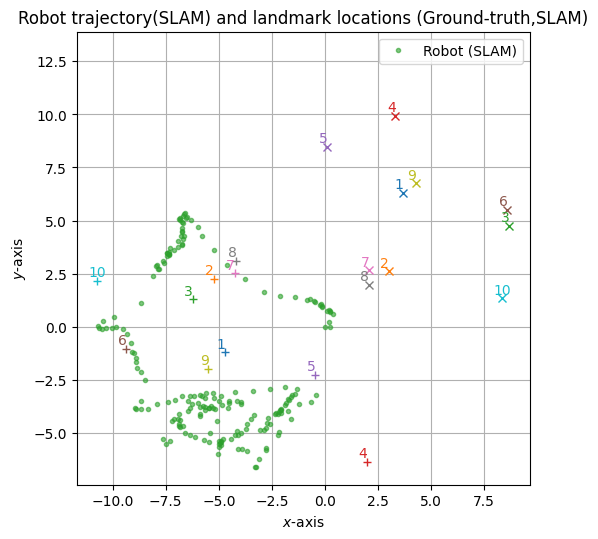

In [6]:
def Trans_Dynamics(state_var, velocity, ang_velocity, del_t, num_lm): #함수 F
  T = state_var

  T[0]+=velocity*del_t*np.cos(state_var[2])
  T[1]+=velocity*del_t*np.sin(state_var[2])
  T[2]+=ang_velocity*del_t

  return T

def Measure_Equation(state_var): #함수 H
  H = np.zeros(20)

  for i in range(10):
    H[i] = ((state_var[3+2*i]-state_var[0])**2+(state_var[4+2*i]-state_var[1])**2)**0.5
    H[i+10] = np.arctan2((state_var[4+2*i]-state_var[1]),(state_var[3+2*i]-state_var[0]))-state_var[2]

  return H

x_hat = np.zeros((N,23)) #state_vector

sigma = np.eye(23)*10

for i in range(3):
  sigma[i,i]=0

Q_k = np.eye(23)*0.005

R_k = np.eye(20)*0.03

for j in range(10):
  R_k[j,j]=1


for k in range(1,N): #1,2,3 단계 순차적으로 진행 후 4단계(반복)
  x_hat_temp = Trans_Dynamics(x_hat[k-1,:],vel_odmtry[k],omg_odmtry[k],dt, n_landmarks) #vel, w = k이므로, x_hat 임시값
  sigma_temp = Jacobian_f(x_hat[k-1,:], vel_odmtry[k], dt, n_landmarks)@sigma@Jacobian_f(x_hat[k-1,:], vel_odmtry[k], dt, n_landmarks).T+Q_k #k-1 이므로, sigma 임시값
  K = sigma_temp@Jacobian_h(x_hat_temp, n_landmarks).T@np.linalg.inv(Jacobian_h(x_hat_temp, n_landmarks)@sigma_temp@Jacobian_h(x_hat_temp, n_landmarks).T+R_k)
  y_k = np.hstack((rng_lidar[:,k].T,brg_lidar[:,k].T))
  x_hat[k,:] = x_hat_temp + K@(y_k-Measure_Equation(x_hat_temp))
  sigma = (np.eye(23)-K@Jacobian_h(x_hat_temp, n_landmarks))@sigma_temp

plt.figure(dpi=100, figsize=(6,6))
for i in range(n_landmarks):
  plt.plot(pos_landmarks[0,i], pos_landmarks[1,i], 'x', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(pos_landmarks[0,i]-0.4, pos_landmarks[1,i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
  
  plt.plot(x_hat[-1,3+2*i], x_hat[-1,4+2*i], '+', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(x_hat[-1,3+2*i]-0.4, x_hat[-1,4+2*i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
    
plt.plot(x_hat[:,0], x_hat[:,1], '.', alpha=0.6, \
         color=plt.cm.tab20(4), label='Robot (SLAM)') #SLAM 궤적
plt.axis('square')
plt.legend()
plt.title('Robot trajectory(SLAM) and landmark locations (Ground-truth,SLAM)')
plt.xlabel(r'$x$-axis')
plt.ylabel(r'$y$-axis')
plt.grid()
plt.show()

<br>

_**(Problem 1d - Scene matching)**_ Since the SLAM performs the _relative_ navigation with relative range and bearing sensors, it only provides the _relative_ geometry and trajectories between the robot and the landmarks.

It means that 1) the plot you obtained from the previous problem and the ground truth plot may not match directly, 2) however they should closely match if one of them is rotated (with by some appropriate angle) and shifted (with some appropriate amount). In this problem we will find the rotation and the shift that help you to overlap and compare the two plots (your estimation and the ground-truth).

In order for finding such rotation and shift, we will compare the landmark positions from the given ground-truth data, and the landmark positions that were obtained from your SLAM solution. Let $m^{(i)}=\left(m_x^{(i)},m_y^{(i)}\right)$ be the ground-truth position of the $i$-th landmark, and let $\hat{m}^{(i)}=\left(\hat{m}_x^{(i)},\hat{m}_y^{(i)}\right)$ be the (final) position estimate of the $i$-th landmark obtained from your SLAM solution at $t_N$. Then for some rotation matrix $A\in\R^{2\times 2}$ and a vector $b\in\R^2$, what we want is

$$
  {m}^{(i)} \approx A \hat{m}^{(i)}+b
$$

for all $i=1,\dots,10$. Then the problem boils down to finding the optimal $A$ and $b$ that minimizes the square sum of the above discrepancy over all the landmarks, so they can be found via solving the following. (Although the square matrix $A$ requires extra technical conditions for being a pure rotation matrix, nevermind; we will ignore it at the expense of a bit of accuracy loss.)

\begin{aligned}
  \underset{A,b}{\minimize} \quad & \sum_{i=1}^{10} 
  \left\|  A \hat{m}^{(i)}+b - {m}^{(i)} \right\|_2^2
\end{aligned}

Find the optimal rotation matrix $A$ and the optimal shift vector $b$. _Hint: Try to get rid of the summation expression ($\sum_{i=1}^{10}$) from above, then it will look like a least squares problem._



In [7]:
from sklearn.linear_model import LinearRegression

pos_slam = [[x_hat[-1,3+2*0],x_hat[-1,4+2*0]],
            [x_hat[-1,3+2*1],x_hat[-1,4+2*1]],
            [x_hat[-1,3+2*2],x_hat[-1,4+2*2]],
            [x_hat[-1,3+2*3],x_hat[-1,4+2*3]],
            [x_hat[-1,3+2*4],x_hat[-1,4+2*4]],
            [x_hat[-1,3+2*5],x_hat[-1,4+2*5]],
            [x_hat[-1,3+2*6],x_hat[-1,4+2*6]],
            [x_hat[-1,3+2*7],x_hat[-1,4+2*7]],
            [x_hat[-1,3+2*8],x_hat[-1,4+2*8]],
            [x_hat[-1,3+2*9],x_hat[-1,4+2*9]]]

mlr_x = LinearRegression()  
mlr_x.fit(pos_slam, pos_landmarks[0,:]) #a11,a12,b1 얻기 위해서

mlr_y = LinearRegression()
mlr_y.fit(pos_slam, pos_landmarks[1,:]) #a21,a22,b2 얻기 위해서

A = np.vstack((mlr_x.coef_,mlr_y.coef_)) #계수 A로 쌓기
b = [mlr_x.intercept_,mlr_y.intercept_]  #상수항 B

print(mlr_x.coef_)
print(mlr_x.intercept_)

print(mlr_y.coef_)
print(mlr_y.intercept_)

print(A,b)



[-0.85850176 -0.50098875]
0.15666382304899873
[ 0.12426681 -0.83646184]
5.50568870375664
[[-0.85850176 -0.50098875]
 [ 0.12426681 -0.83646184]] [0.15666382304899873, 5.50568870375664]


<br>

_**(Problem 1e - Final results)**_ Rotate and shift your position estimates (of the robot and the landmarks) from the SLAM solution, by using the rotation matrix $A$ and the shift vector $b$. Present a comprehensive 2D plot displaying the following.

- Ground-truth trajectory of the robot.
- Ground-truth positions of the landmarks (marked 'x').
- Estimated trajectory of the robot, obtained from dead reckoning.
- Estimated trajectory of the robot, obtained from the SLAM solution (rotated and shifted).
- Estimated positions of the landmarks (marked '+'), obtained from the SLAM solution at $t_N$ (rotated and shifted).

If everything is done right, you should expect something like the following picture. Notice that the achieved SLAM solution is quite accurate, even though a LIDAR with very poor quality was used; recall that the LIDAR's accuracy was about 1 meter in range and 10 degrees in bearing.

<center>
<img src="https://jonghank.github.io/ee370/files/SLAM_final_results.png" width="500">
</center>


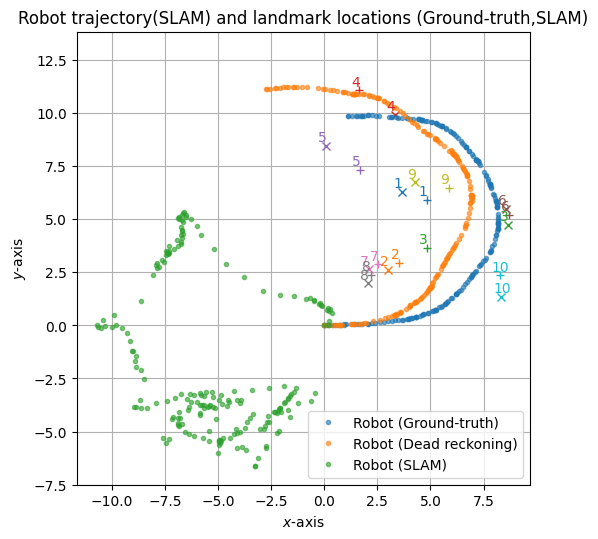

In [8]:
def RotnShift(state_var): #회전 및 이동 함수 : x_hat의 m_x,m_y를 업데이트 하려고 했지만 함수 적용 시 자꾸 발산해 결국 활용 실패
  for i in range(10):
    state_var[3+2*i] = A[0,0]*state_var[3+2*i]+A[0,1]*state_var[4+2*i]+b[0]
    state_var[4+2*i] = A[1,0]*state_var[3+2*i]+A[1,1]*state_var[4+2*i]+b[1]

plt.figure(dpi=100, figsize=(6,6))
for i in range(n_landmarks):
  plt.plot(pos_landmarks[0,i], pos_landmarks[1,i], 'x', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(pos_landmarks[0,i]-0.4, pos_landmarks[1,i]+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
  
  pos_slam_x = A[0,0]*x_hat[-1,3+2*i]+A[0,1]*x_hat[-1,4+2*i]+b[0]
  pos_slam_y = A[1,0]*x_hat[-1,3+2*i]+A[1,1]*x_hat[-1,4+2*i]+b[1]
  
  plt.plot(pos_slam_x, pos_slam_y, '+', \
           color=plt.cm.tab20(i/n_landmarks))
  plt.text(pos_slam_x-0.4, pos_slam_y+0.2, f'{i+1}', \
           color=plt.cm.tab20(i/n_landmarks))
  
plt.plot(pos_robot[0,:], pos_robot[1,:], '.', alpha=0.6, \
         color=plt.cm.tab20(0), label='Robot (Ground-truth)') #로봇 궤적
plt.plot(pos_robot_dr[0,:], pos_robot_dr[1,:], '.', alpha=0.6, \
         color=plt.cm.tab20(2), label='Robot (Dead reckoning)') #Dead reckoning 궤적   
plt.plot(x_hat[:,0], x_hat[:,1], '.', alpha=0.6, \
         color=plt.cm.tab20(4), label='Robot (SLAM)') #SLAM 궤적
plt.axis('square')
plt.legend()
plt.title('Robot trajectory(SLAM) and landmark locations (Ground-truth,SLAM)')
plt.xlabel(r'$x$-axis')
plt.ylabel(r'$y$-axis')
plt.grid()
plt.show()
